# Standardized Indices

*Martin Vonk - 2022*

This notebooks shows an example calculation of the three drought indices:
- SPI: Standardized Precipitation Index
- SPEI: Standardized Precipitation Evaporation Index
- SGI: Standardized Groundwater Index

## Required packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs

import spei as si  # si for standardized index

print(si.show_versions())

python: 3.11.13
spei: 0.8.0
numpy: 2.2.6
scipy: 1.16.0
matplotlib: 3.10.3
pandas: 2.3.1


## Load time series

We use time series of the precipitation and potential (Makkink) evaporation from the Netherlands and obtain them from the python package [Pastas](https://github.com/pastas/pastas).

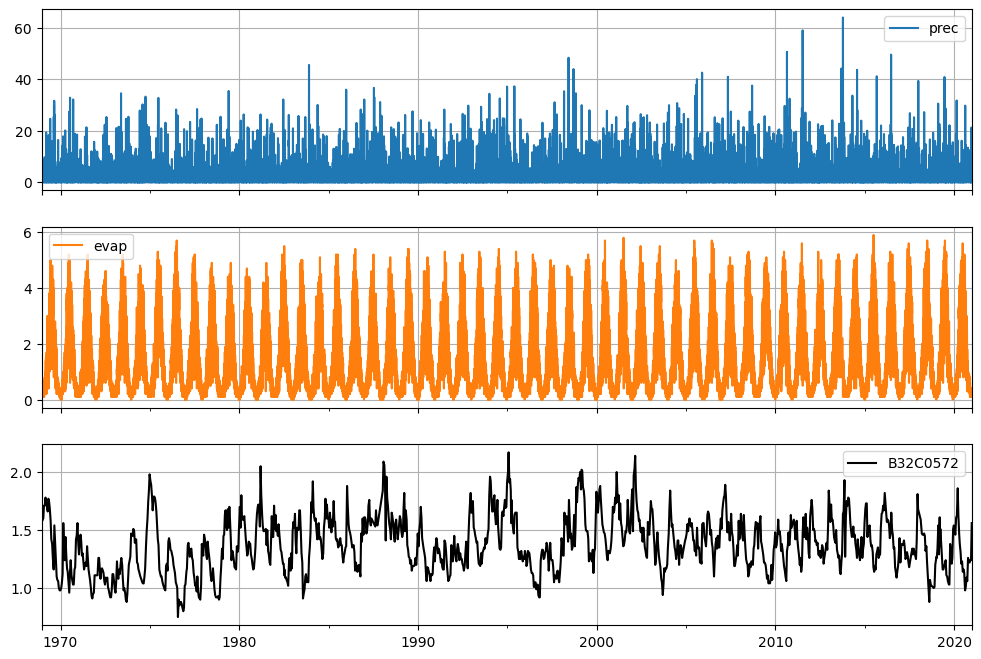

In [2]:
df = pd.read_csv("data/DEBILT.csv", index_col=0, parse_dates=True)
prec = df["Prec [m/d] 260_DEBILT"].multiply(1e3).rename("prec")
evap = df["Evap [m/d] 260_DEBILT"].multiply(1e3).rename("evap")
head = df["Head [m] B32C0572_DEBILT"].rename("B32C0572").dropna()

fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
prec.plot(ax=ax[0], legend=True, grid=True)
evap.plot(ax=ax[1], color="C1", legend=True, grid=True)
head.plot(ax=ax[2], color="k", legend=True, grid=True);

## Calculate SPI

The standardized precipitation index (SPI) is calculated using the gamma distribution from the [scipy stats library](https://docs.scipy.org/doc/scipy/reference/stats.html). In fact any continuous distribution of this library can be chosen. However there are sensible choices for the SPI such as gamma, lognorm (lognormal), fisk (log-logistic) or pearson3 distribution. The precipitation time series is summed over a 90D rolling interval, which corresponds to SPI3. 

For the literature we refer to: LLoyd-Hughes, B. and Saunders, M.A.: [A drought climatology for Europe](https://doi.org/10.1002/joc.846), 2002.

In [3]:
f = 90  # days
series = prec.rolling(f, min_periods=f).sum().dropna()
series

1959-09-28    79.1
1959-09-29    76.2
1959-09-30    75.8
1959-10-01    70.0
1959-10-02    68.1
              ... 
2025-05-08    72.2
2025-05-09    72.2
2025-05-10    72.2
2025-05-11    72.2
2025-05-12    68.2
Name: prec, Length: 23969, dtype: float64

In [4]:
spi3_gamma = si.spi(series, dist=scs.gamma, fit_freq="ME")
spi3_gamma

1959-09-28   -1.946497
1959-09-29   -1.987499
1959-09-30   -1.993159
1959-10-01   -1.341970
1959-10-02   -1.359484
                ...   
2025-05-08   -1.823940
2025-05-09   -1.823940
2025-05-10   -1.823940
2025-05-11   -1.823940
2025-05-12   -1.908646
Length: 23969, dtype: float64

Lets try that with the pearson3 distribution:

In [5]:
spi3_pearson = si.spi(series, dist=scs.pearson3, fit_freq="ME")
spi3_pearson

1959-09-28   -1.996768
1959-09-29   -2.040934
1959-09-30   -2.047037
1959-10-01   -2.239332
1959-10-02   -2.268179
                ...   
2025-05-08   -1.849617
2025-05-09   -1.849617
2025-05-10   -1.849617
2025-05-11   -1.849617
2025-05-12   -1.938307
Length: 23969, dtype: float64

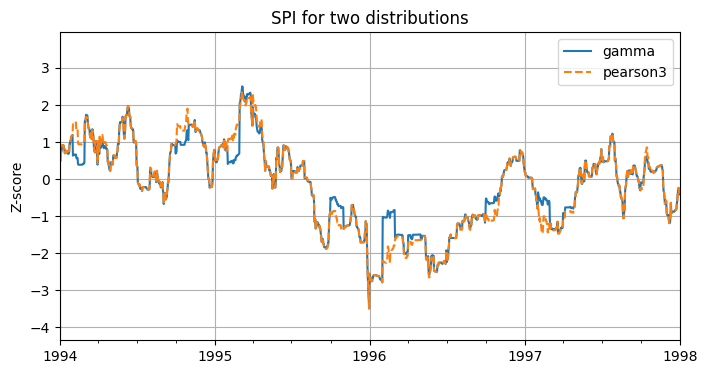

In [6]:
tmin, tmax = pd.to_datetime(["1994", "1998"])
plt.figure(figsize=(8, 4))
spi3_gamma.plot(label="gamma")
spi3_pearson.plot(label="pearson3", linestyle="--")
plt.xlim(tmin, tmax)
plt.legend()
plt.ylabel("Z-score")
plt.grid()
plt.title("SPI for two distributions");

As can be seen from the figure the distributions do not give significantly different output. This might not be the case for other time series of the precipitation. Example notebook 2 (example2_distribution.ipynb) provides more insight in how to choose the right distribution.

## Calculate SPEI

The standardized precipitation evaporation index (SPEI) is calculated by first substracting the evaporation from the precipitation time series. By default the fisk distribution is used to calculate the SPEI, however for other regularly used distributions are lognorm, pearson3 and genextreme. The code internally can also calculate the timescale (30D; SPEI1 in this case)

For the literature we refer to: Vicente-Serrano S.M., Beguería S., López-Moreno J.I.: [A Multi-scalar drought index sensitive to global warming: The Standardized Precipitation Evapotranspiration Index](https://doi.org/10.1175/2009JCLI2909.1), 2010.

In [7]:
pe = (prec - evap).dropna()  # calculate precipitation excess
spei1 = si.spei(pe, timescale=30, fit_freq="ME")
spei1

1959-07-30   -1.353171
1959-07-31   -1.067108
1959-08-01   -0.996005
1959-08-02   -1.184182
1959-08-03   -1.223476
                ...   
2025-05-08   -0.882752
2025-05-09   -0.892700
2025-05-10   -0.932472
2025-05-11   -0.998673
2025-05-12   -1.058134
Length: 24029, dtype: float64

## Calculate SGI

The standardized groundwater index (SGI) is calculated using the method as described by [Bloomfield, J. P. and Marchant, B. P.: Analysis of groundwater drought building on the standardised precipitation index approach](https://doi.org/10.5194/hess-17-4769-2013), 2013. The way the SGI is calculated is the same as in the groundwater time series analysis package Pastas. A nice example notebook on computing the SGI with Pastas time series models can be found [here](https://pastas.readthedocs.io/en/latest/examples/011_sgi_example.ipynb.html).

For the head time series no distribution has to be selected by default. Since the time series has a 14 day frequency it is not resampled.

<Axes: ylabel='Z-score'>

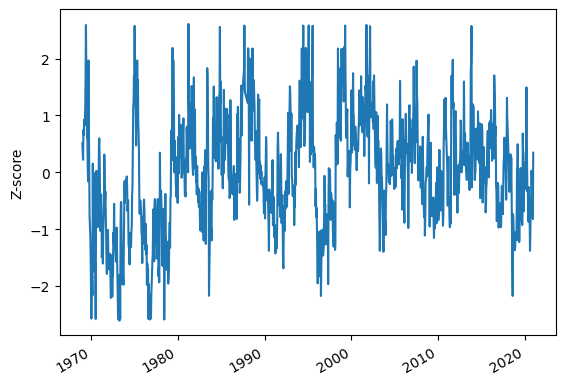

In [8]:
sgi = si.sgi(head, fit_freq="ME")
sgi.plot(ylabel="Z-score")

## Visualize indices

The indices can be interpreted as such:

| **Z-score**           | **Category**         | **Probability (%)** |
|-----------------------|----------------------|---------------------|
| ≥ 2.00                | Extremely wet        | 2.3                 |
| 1.50 ≤ Z < 2.00       | Severely wet         | 4.4                 |
| 1.00 ≤ Z < 1.50       | Moderately wet       | 9.2                 |
| 0.00 ≤ Z < 1.00       | Mildly wet           | 34.1                |
| -1.00 < Z < 0.00      | Mild drought         | 34.1                |
| -1.50 < Z ≤ -1.00     | Moderate drought     | 9.2                 |
| -2.00 < Z ≤ -1.50     | Severe drought       | 4.4                 |
| ≤ -2.00               | Extreme drought      | 2.3                 |

The time series for the standardized indices are plotted using a build in method:

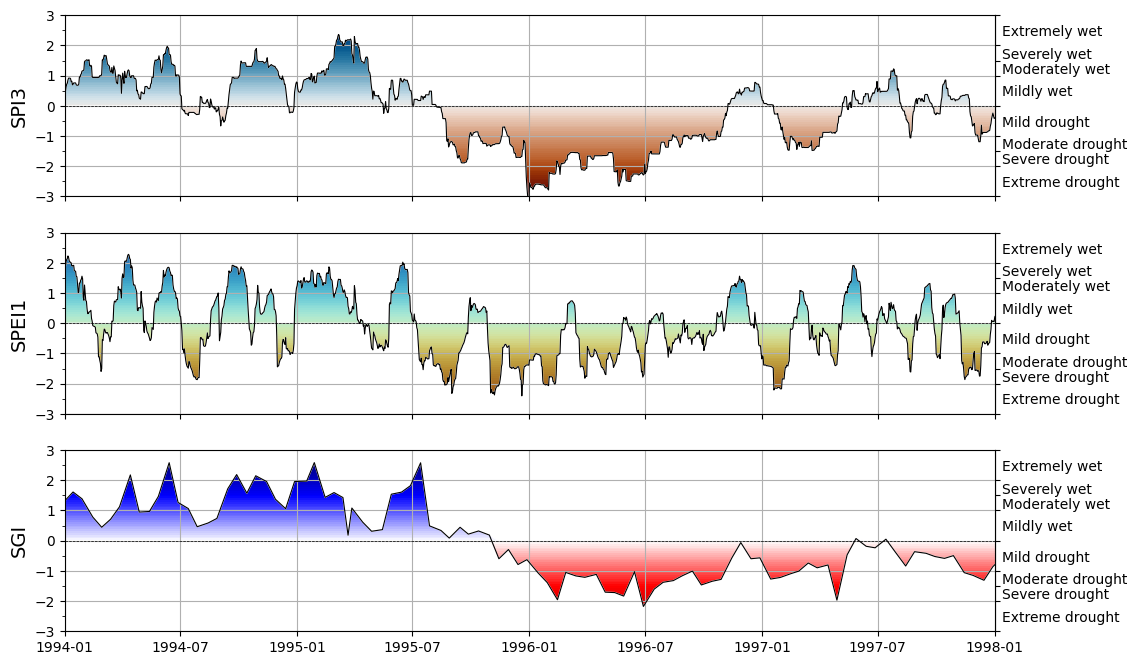

In [9]:
f, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# choose a colormap to your liking:
si.plot.si(spi3_pearson, ax=ax[0], cmap="vik_r")
si.plot.si(spei1, ax=ax[1], cmap="roma")
si.plot.si(sgi, ax=ax[2], cmap="seismic_r")
ax[0].set_xlim(pd.to_datetime(["1994", "1998"]))
[x.grid() for x in ax]
[ax[i].set_ylabel(n, fontsize=14) for i, n in enumerate(["SPI3", "SPEI1", "SGI"])];